In [1]:
import json
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import numpy as np
from tqdm import tqdm

from model import ResNet18, LeNet5
from pgd_attack import LinfPGDAttack
from train import train_one_epoch, evaluate

with open('config.json') as config_file:
    config = json.load(config_file)

# randomness control
torch.manual_seed(config['torch_random_seed'])
np.random.seed(config['np_random_seed'])

# GPU check
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# training parameters
max_num_epochs = config['max_num_epochs']
step_size_start = config['step_size_start']
step_size_schedule = config['step_size_schedule']
step_size_decay = config['step_size_decay']
weight_decay = config['weight_decay']
data_path = config['data_path']
momentum = config['momentum']
batch_size = config['training_batch_size']
dataset = config['dataset']
adv_training = config['train_with_adversary']



In [2]:
# set up data and model
to_tensor = torchvision.transforms.PILToTensor()
to_double = torchvision.transforms.ConvertImageDtype(torch.double)
cifar_transform = torchvision.transforms.Compose([to_tensor,
                                                  to_double])
num_classes = 10
cifar_train_data = torchvision.datasets.CIFAR10(data_path,
                                                transform=cifar_transform,
                                                train=True,
                                                download=True)
cifar_test_data = torchvision.datasets.CIFAR10(data_path,
                                               transform=cifar_transform,
                                               train=False,
                                               download=True)

train_data = torch.utils.data.DataLoader(cifar_train_data,
                                         batch_size=batch_size,
                                         shuffle=True)
test_data = torch.utils.data.DataLoader(cifar_test_data,
                                        batch_size=batch_size,
                                        shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
n = 25
epsilons = np.linspace(0, 0.5, num=n)
adv_acc_results = np.zeros((n, n+1))
adv_loss_results = np.zeros((n, n+1))
loss_func = nn.CrossEntropyLoss()
for i in tqdm(range(n)):
    model = LeNet5(num_classes).double().to(device)
    optimizer = optim.SGD(model.parameters(), lr=step_size_start,
                          momentum=momentum, weight_decay=weight_decay)
    lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=step_size_schedule,
                                            gamma=step_size_decay)
    # DEFENDER
    defender = LinfPGDAttack(model,
                             epsilons[i],
                             config['num_steps'],
                             config['step_size'],
                             config['random_start'],
                             device)
    for e in range(max_num_epochs):
        train_one_epoch(model, loss_func, optimizer, train_data, defender, device)
    for j in range(n):
        # ATTACKER
        attacker = LinfPGDAttack(model,
                                epsilons[j],
                                config['num_steps'],
                                config['step_size'],
                                config['random_start'],
                                device)
        (nat_loss, nat_acc), (adv_loss, adv_acc) = evaluate(model,
                                                            loss_func,
                                                            test_data,
                                                            attacker,
                                                            device)
        adv_loss_results[i][j+1] = adv_loss
        adv_acc_results[i][j+1] = adv_acc
    adv_loss_results[i][0] = nat_loss
    adv_acc_results[i][0] = nat_acc

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [3:39:45<00:00, 527.42s/it]


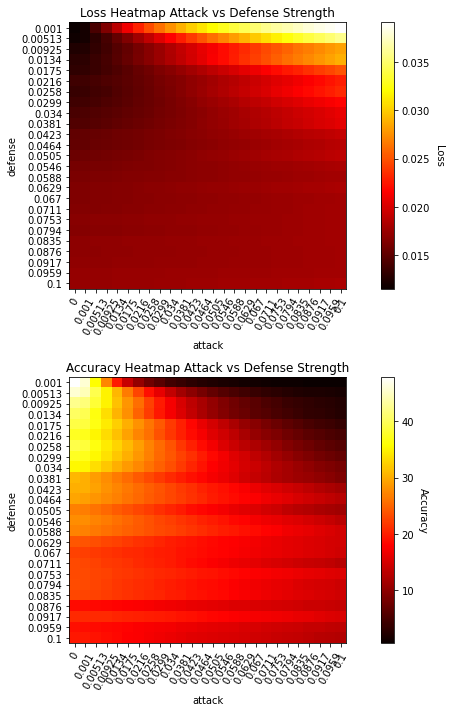

In [6]:
import matplotlib.pyplot as plt

# plot heatmap of accuracy
y_axis_labels = [f'{x:.3}' for x in epsilons]
x_axis_labels = ['0'] + y_axis_labels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
im1 = ax1.imshow(adv_loss_results, cmap='hot')
ax1.set_title('Loss Heatmap Attack vs Defense Strength')
ax1.set_xlabel('attack')
ax1.set_ylabel('defense')
ax1.set_yticks(range(n), labels=y_axis_labels)
ax1.set_xticks(range(n+1), labels=x_axis_labels, rotation=60)
cbar1 = ax1.figure.colorbar(im1, ax=ax1)
cbar1.ax.set_ylabel('Loss', rotation=-90, va="bottom")
im2 = ax2.imshow(adv_acc_results, cmap='hot')
ax2.set_title('Accuracy Heatmap Attack vs Defense Strength')
ax2.set_xlabel('attack')
ax2.set_ylabel('defense')
ax2.set_yticks(range(n), labels=y_axis_labels)
ax2.set_xticks(range(n+1), labels=x_axis_labels, rotation=60)
cbar2 = ax2.figure.colorbar(im2, ax=ax2)
cbar2.ax.set_ylabel('Accuracy', rotation=-90, va="bottom")
fig.tight_layout()
plt.savefig(f'epsilon_heatmaps_{n}.png')
plt.show()

In [7]:
# Experiment for n = 25 takes about 4 hours on GPU (NVIDIA 3070) so we want to save this data
# TODO: add row for 0 defense in plot above, should be able to load these files,
# compute the row, and re-create the plots
adv_loss_results.tofile(f'epsilon_loss_data_{n}.csv', sep=',')
adv_acc_results.tofile(f'epsilon_accuracy_data_{n}.csv', sep=',')